Nombre: 
 
Clave:  

# Recomendacion de Modelo de Default Para Banco

El objetivo de este proyecto es entrenar un modelo y recomendar al banco como utilizarlo.  
Puedes agregar mas snippets, usar fuentes de internet, otras librerias, comentar con otras personas, pero asegurate de ser muy explicitx con tu explicacion. Imagina que este documento lo va a evaluar una persona técnica y una persona no tecnica, por lo que tienes que ser muy cuidadosx con lo que dices pues tiene que ser verdad y no tener errores metodológicos, pero también partes que sean faciles de leer.

1. Deberas replicar el analisis/codigo que utilizamos en el `AutoML` coun autogluon (o con cualquier otra libreria que desees), pero tendras que elimar la columna que especifica la `tasa de interes` o columnas equivalentes.  
   
2. Debes elegir (entrenar) dos modelo que no tenga `leakage`, que sean estadisticamente robustos y utiles para la operacion. Debes explicar de manera detallada con graficas, tablas y palabras por que propones el uso de cada modelo
   1. El primer modelo debe ser explicable (por regulacion debes ser capaz de explicar por que no se da el prestamo). Ofrece una guia para explicar como podria defenderse el banco con el modelo que promones
   2. El segundo debe ser elegido sin importar si es explicable o no  
   
3. Finalmente usando uno de los modelos anteriores (elige el que quieras) debes proponer al banco que tasa de interes utilizar para los prestamos (basandose en la probabilidad del modelo) bajo los siguientes escenarios
   1. El banco no es adverso al riesgo y quiere saber cual es la minima tasa a la que deberia prestar para no perder o ganar dinero (Valor esperado del prestamo igual a cero)
   2. El banco es adverso al riesgo y busca la tasa para la cual el valor esperado del prestamo represente una ganancia de 1.5 sobre el prestamo (Valor esperado del prestamo 1.5)
   3. El banco quiere obtener 1.2 veces el valor del prestamo, pero quiere que por lo menos el 30% de los prestamos realizados sean pagados (en promedio o valor esperado) 

# Codigo para prediccion

En esta seccion deberas replicar el proceso de entramiento para los dos modelos (interpretable y no interpretable)  
+ Utiliza los mismos datos que usamos en el proyecto de AutoML
+ Recuerda que debes quitar todas las columnas que incluyan la tasa de interes en tu prediccion, pues deberas proponer la tasa de interes mas tarde

## ETL

In [45]:
# cargamos las librerias necesarias
import os
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import (train_test_split, KFold, cross_val_score, 
GridSearchCV, StratifiedKFold)
import numpy as np

In [46]:
# Cargamos los datos, si no existen los descargamos
if os.path.isfile('loans_sampe_data.parquet'):
    loans = pd.read_parquet('loans_sampe_data.parquet')
else:
    print('Descargando Datos...')
    loans = pd.read_parquet('https://github.com/sonder-art/automl_o23/raw/main/codigo/intro_ml/loans_sampe_data.parquet')
    loans.to_parquet('loans_sampe_data.parquet')

In [47]:
loans.columns

Index(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=151)

In [48]:
# datos dict contiene la informacion de cada variable
datos_dict = pd.read_excel('https://resources.lendingclub.com/LCDataDictionary.xlsx')
datos_dict.columns = ['feature', 'description']

In [49]:
# para poder decidir una tasa de interés para un préstamo, es necesario saber si el prestatario pagará o no el préstamo
# por lo que la variable objetivo es loan_status
datos_dict[datos_dict.feature == 'loan_status']

,feature,description
42,loan_status,Current status of the loan


In [50]:
# veamos que valores tiene la variable objetivo
loans.loan_status.value_counts(dropna=False)

Fully Paid            69982
Charged Off           16156
Current               12726
Late (31-120 days)      730
In Grace Period         264
Late (16-30 days)       139
Default                   3
Name: loan_status, dtype: int64

In [51]:
# nos quedamos con los prestamos que estan pagados o que estan en mora ya que son los que nos interesan
loans = loans[loans.loan_status.isin(['Fully Paid', 'Charged Off'])]
print(loans.loan_status.value_counts())
print("--- En proporciones ---")
print(loans.loan_status.value_counts(normalize=True, dropna=False))

Fully Paid     69982
Charged Off    16156
Name: loan_status, dtype: int64
--- En proporciones ---
Fully Paid     0.812441
Charged Off    0.187559
Name: loan_status, dtype: float64


In [52]:
# ya que no tiene sentido tener la variable objetivo en texto, la transformamos a 0 y 1
# 0 = Fully Paid, 1 = Charged Off
# apply aplica una funcion a cada elemento de la serie y en este caso la funcion es np.uint8
# que transforma el tipo de dato a un entero de 8 bits sin signo, no usamos un int nomal ya que
# ocupan mas espacio en memoria (32 bits) y no es necesario
loans['charged_off'] = (loans.loan_status == 'Charged Off').apply(np.uint8) # True = 1, False = 0
# ya que tenemos la variable objetivo en 0 y 1, podemos eliminar la variable loan_status
loans.drop('loan_status', axis=1, inplace=True)
# veamos como quedo la variable objetivo
print("--- En proporciones ---")
print(loans.charged_off.value_counts(normalize=True, dropna=False))

--- En proporciones ---
0    0.812441
1    0.187559
Name: charged_off, dtype: float64


## EDA

Lo único que podíamos hacer sin separar los datos era poner la variable objetivo en 0 y 1, pero ahora que tenemos la variable objetivo en 0 y 1, de ahora en adelante, para evitar el data leakage, debemos separar los datos en train y test y luego aplicar cualquier transformación a los datos de train y luego aplicar la misma transformación a los datos de test.

In [53]:
# lo primero que hacemos es separar los datos en train, validation y test para evitar data leakage
# train: para estimar los parámetros del modelo
# validation: para ajustar los hiperparámetros del modelo
# test: para evaluar el modelo final como si estuvieramos en producción
a_train, a_test = train_test_split(loans,
                                         stratify=loans['charged_off'],
                                         test_size=0.2, random_state=453890)

a_train, a_val = train_test_split(a_train,stratify=a_train['charged_off'],
                                         test_size=0.2, random_state=7568)

Para el EDA nos apoyaremos de la librería `autogluon.eda`.

In [54]:
import autogluon.eda.auto as auto

In [55]:
# para el EDA vamos a juntar los datos de train y validation para no duplicar código y esfuerzo
all_train = pd.concat([a_train, a_val], axis=0, ignore_index=True).copy() # copy es para no solo hacer referencia a los datos
all_train

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,charged_off
0,76544,26229999,NaN,16000.0,16000.0,16000.0,36 months,16.99,570.37,D,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,0
1,65048,28893716,NaN,8000.0,8000.0,8000.0,36 months,9.17,255.04,B,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,0
2,71420,28382451,NaN,28775.0,28775.0,28775.0,36 months,14.49,990.33,C,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,0
3,32390,33251700,NaN,20000.0,20000.0,20000.0,36 months,12.99,673.79,C,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,0
4,84410,26087809,NaN,15000.0,15000.0,15000.0,36 months,9.17,478.19,B,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68905,38250,32399529,NaN,15000.0,15000.0,15000.0,60 months,14.49,352.85,C,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,0
68906,74036,27642003,NaN,1400.0,1400.0,1400.0,36 months,15.61,48.96,D,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,0
68907,12956,35713975,NaN,28000.0,28000.0,28000.0,60 months,11.99,622.71,B,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,0
68908,84729,26067703,NaN,10000.0,10000.0,9900.0,36 months,10.15,323.38,B,...,NaN,Cash,N,None,None,None,NaN,NaN,NaN,0


### Valores faltantes


### Missing Values Analysis

,missing_count,missing_ratio
member_id,10000,1.0000
emp_title,555,0.0555
emp_length,555,0.0555
desc,10000,1.0000
mths_since_last_delinq,4902,0.4902
mths_since_last_record,8281,0.8281
revol_util,5,0.0005
last_pymnt_d,8,0.0008
next_pymnt_d,10000,1.0000
last_credit_pull_d,2,0.0002


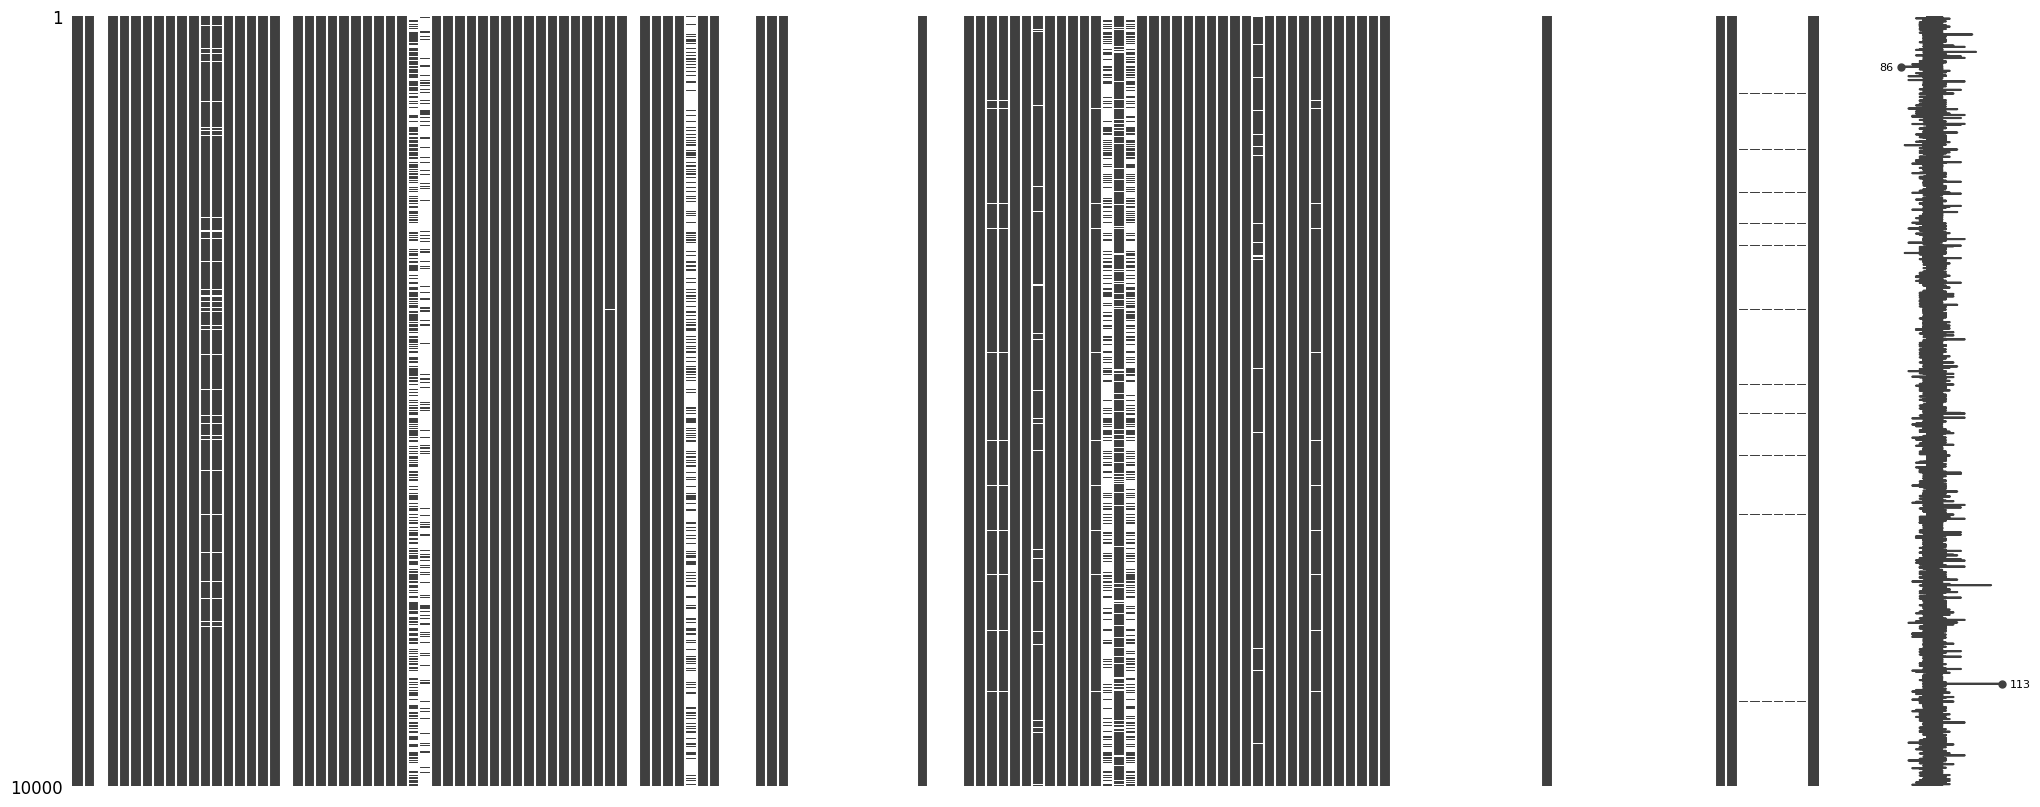

In [56]:
missings = auto.missing_values_analysis(train_data=all_train)

In [57]:
# podemos ver que hay variables con valores faltantes, así que definiremos un umbral para eliminarlas
# en este caso eliminaremos las variables que tengan mas del 90% de valores faltantes
threshold = .9

# Obtenemos las variables que tienen mas del 90% de valores faltantes
null_percentage = (all_train.isnull().sum() / len(all_train))
columns_to_drop = null_percentage[null_percentage > threshold].index
print("--- Variables a eliminar por falta de datos ---")
print(columns_to_drop)
# eliminamos las variables
a_train.drop(columns_to_drop, axis=1, inplace=True) 
a_val.drop(columns_to_drop, axis=1, inplace=True)
all_train.drop(columns_to_drop, axis=1, inplace=True)
# hay que eliminar las mismas variables en test, aunque 
# no sepamos como sea el test ya que en producción no sabemos como se verán los datos
a_test.drop(columns_to_drop, axis=1, inplace=True) 


--- Variables a eliminar por falta de datos ---
Index(['member_id', 'desc', 'next_pymnt_d', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'open_acc_6m', 'open_act_il',
       'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il',
       'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'inq_fi', 'total_cu_tl', 'inq_last_12m', 'revol_bal_joint',
       'sec_app_fico_range_low', 'sec_app_fico_range_high',
       'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
       'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med',
       'sec_app_mths_since_last_major_derog', 'hardship_type',
       'hardship_reason', 'hardship_status', 'deferral_term',
       'hardship_amount', 'hardship_start_date', 'hardship_end_date',
       'payment_plan_start_date', 'hardship_length', 'hardship_dp

**`train_data` dataset summary (sample size: 10000)**

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,variable_type,special_types
Unnamed: 0,10000,10000,,,50464.4835,28923.297905,1.0,25648.0,50357.5,75645.0,99995.0,int64,,,int,numeric,
acc_now_delinq,10000,3,,,0.0057,0.082875,0.0,0.0,0.0,0.0,2.0,float64,,,float,category,
acc_open_past_24mths,10000,26,,,4.6013,3.070941,0.0,2.0,4.0,6.0,42.0,float64,,,float,numeric,
addr_state,10000,46,CA,1437,,,,,,,,object,,,object,category,
annual_inc,10000,1443,,,73178.239042,47513.272586,4000.0,45000.0,62000.0,89000.0,900000.0,float64,,,float,numeric,
application_type,10000,1,Individual,10000,,,,,,,,object,,,object,category,
avg_cur_bal,10000,8039,,,13042.8875,15995.720627,0.0,2942.75,6934.0,18039.5,447433.0,float64,,,float,numeric,
bc_open_to_buy,9888,6859,,,8775.811792,14078.576055,0.0,1089.75,3739.5,10335.75,224525.0,float64,112,0.0112,float,numeric,
bc_util,9882,1048,,,63.870806,27.154072,0.0,44.1,68.15,87.4,141.2,float64,118,0.0118,float,numeric,
charged_off,10000,2,,,0.183,0.386686,0.0,0.0,0.0,0.0,1.0,uint8,,,int,category,


**`test_data` dataset summary (sample size: 10000)**

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,variable_type,special_types
Unnamed: 0,10000,10000,,,50479.9819,28903.488769,12.0,25489.75,50174.5,75792.5,99999.0,int64,,,int,numeric,
acc_now_delinq,10000,5,,,0.0071,0.098237,0.0,0.0,0.0,0.0,4.0,float64,,,float,category,
acc_open_past_24mths,10000,27,,,4.5811,3.058195,0.0,2.0,4.0,6.0,39.0,float64,,,float,numeric,
addr_state,10000,46,CA,1471,,,,,,,,object,,,object,category,
annual_inc,10000,1429,,,73930.624622,52583.752854,6900.0,45000.0,62000.0,89000.0,1250000.0,float64,,,float,numeric,
application_type,10000,1,Individual,10000,,,,,,,,object,,,object,category,
avg_cur_bal,10000,8044,,,13374.1735,17152.44231,0.0,2991.0,6978.5,18252.25,278317.0,float64,,,float,numeric,
bc_open_to_buy,9883,6893,,,8916.250936,13863.52323,0.0,1089.0,3775.0,10620.0,225313.0,float64,117,0.0117,float,numeric,
bc_util,9878,1060,,,63.712533,27.051444,0.0,43.9,67.6,87.5,188.8,float64,122,0.0122,float,numeric,
charged_off,10000,2,,,0.189,0.391528,0.0,0.0,0.0,0.0,1.0,uint8,,,int,category,


### Feature Distance

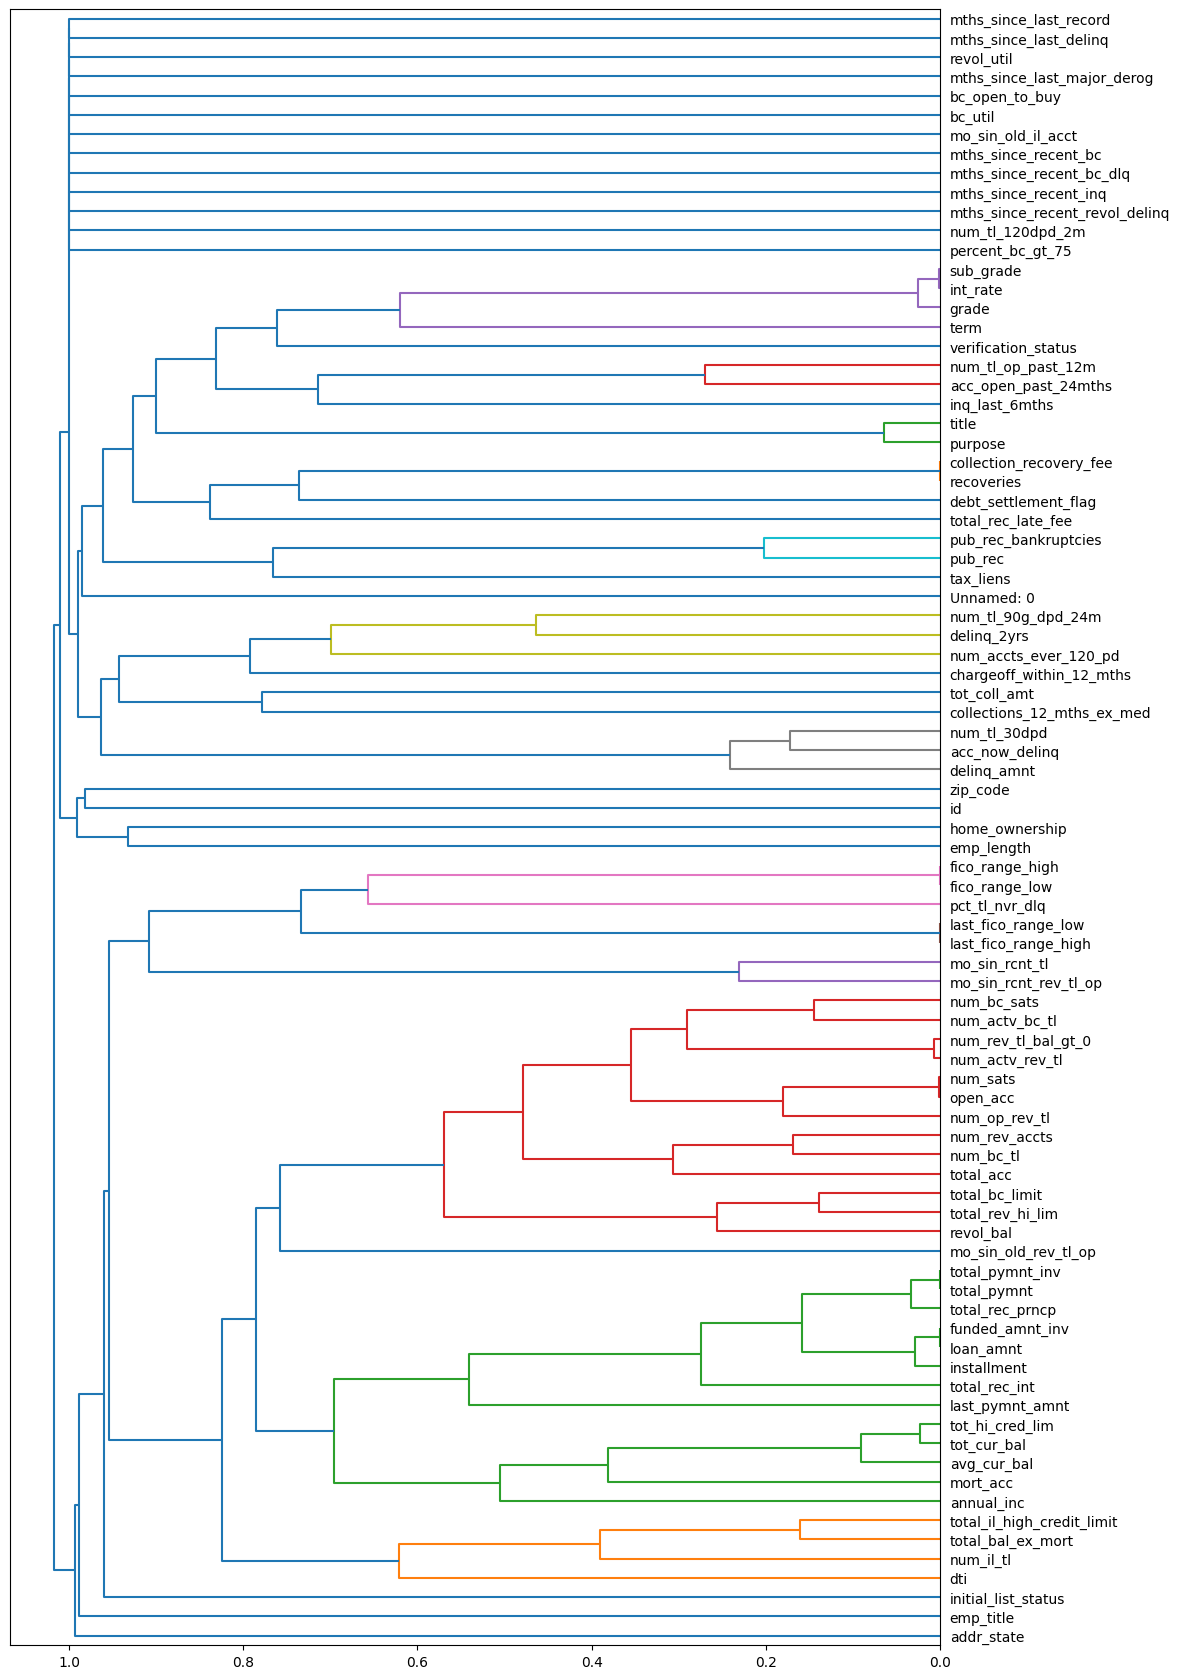

**The following feature groups are considered as near-duplicates**:

Distance threshold: <= `0.01`. Consider keeping only some of the columns within each group:

 - `total_pymnt`, `total_pymnt_inv` - distance `0.00`
 - `fico_range_high`, `fico_range_low` - distance `0.00`
 - `last_fico_range_high`, `last_fico_range_low` - distance `0.00`
 - `funded_amnt_inv`, `loan_amnt` - distance `0.00`
 - `collection_recovery_fee`, `recoveries` - distance `0.00`
 - `num_sats`, `open_acc` - distance `0.00`
 - `int_rate`, `sub_grade` - distance `0.00`
 - `num_actv_rev_tl`, `num_rev_tl_bal_gt_0` - distance `0.01`

Feature interaction between `total_pymnt`/`total_pymnt_inv`

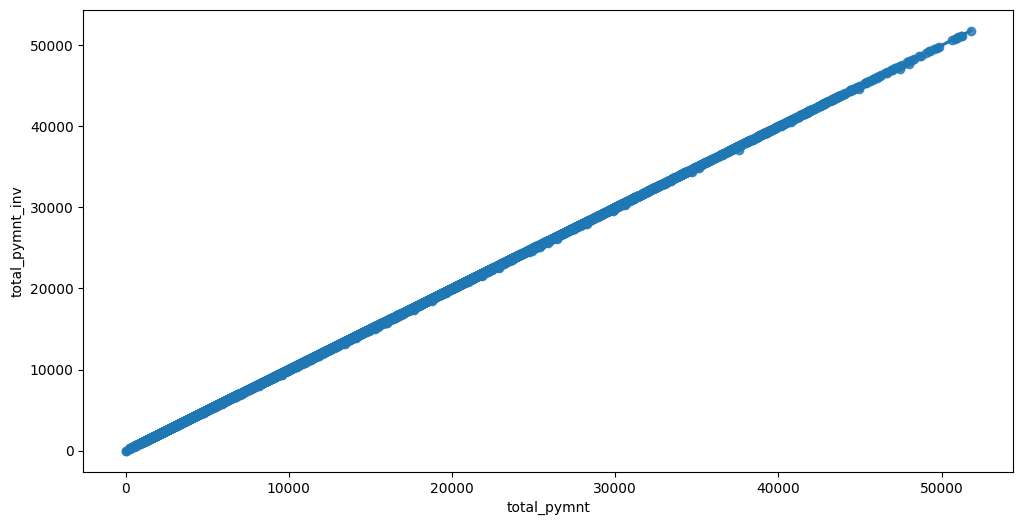

Feature interaction between `fico_range_high`/`fico_range_low`

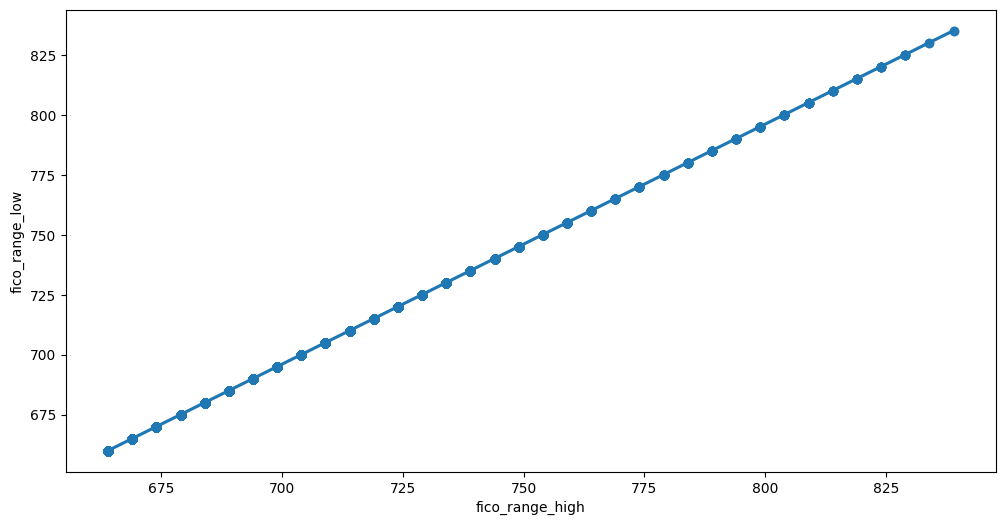

Feature interaction between `last_fico_range_high`/`last_fico_range_low`

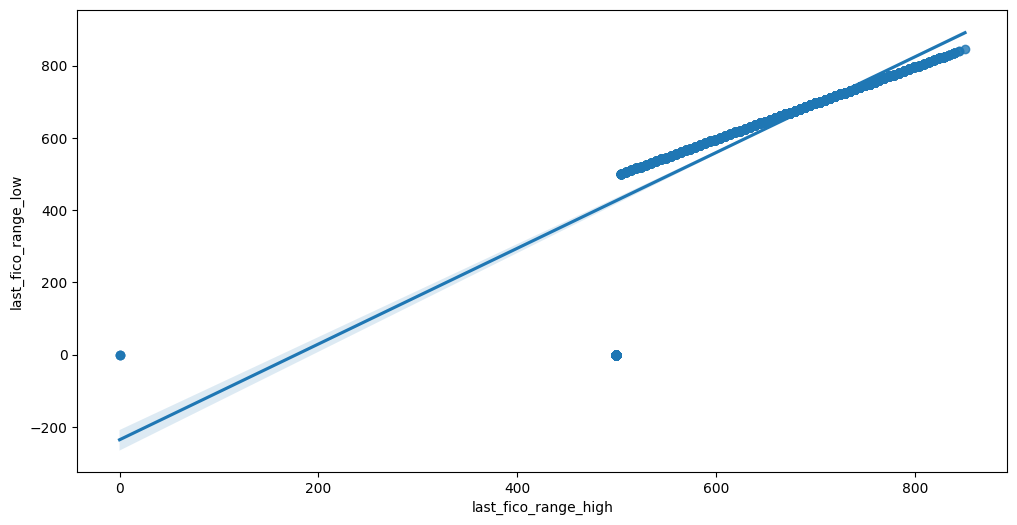

Feature interaction between `funded_amnt_inv`/`loan_amnt`

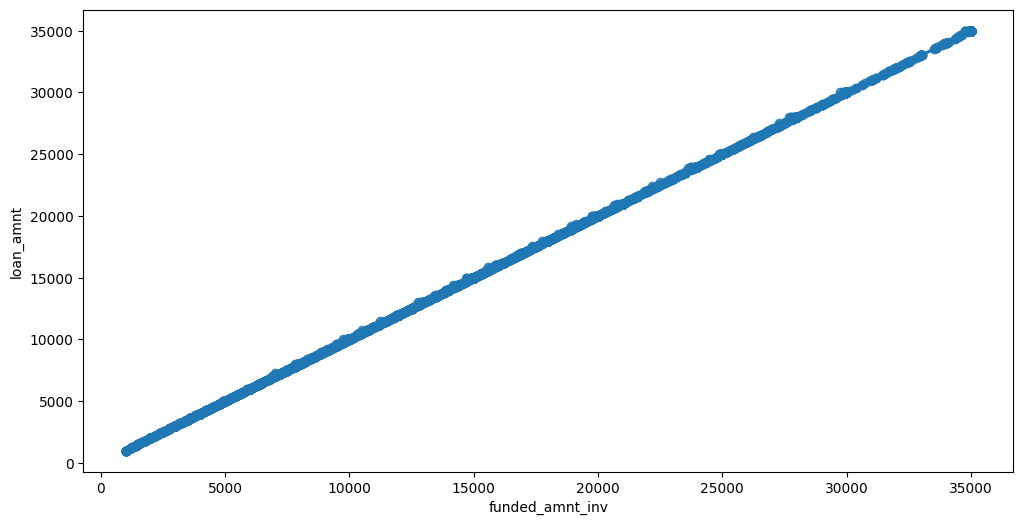

Feature interaction between `collection_recovery_fee`/`recoveries`

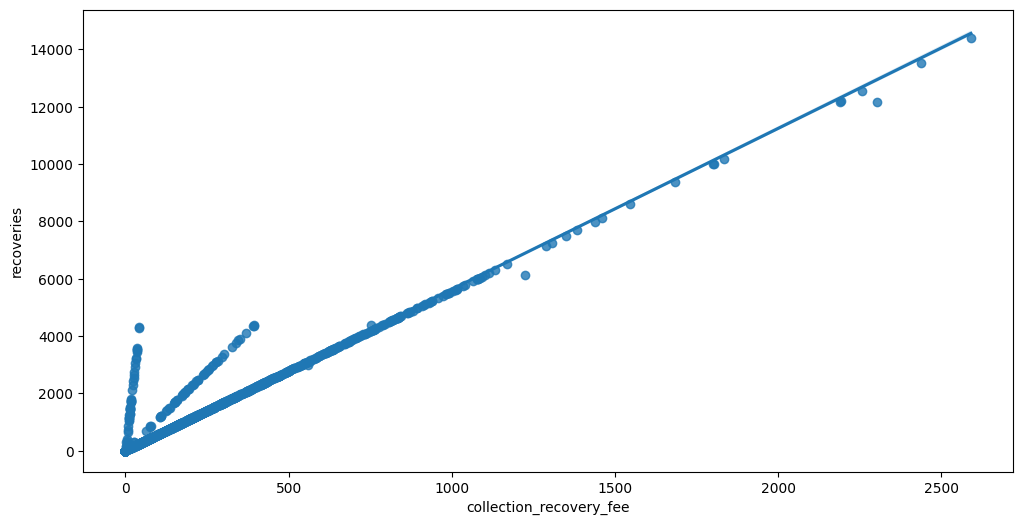

Feature interaction between `num_sats`/`open_acc`

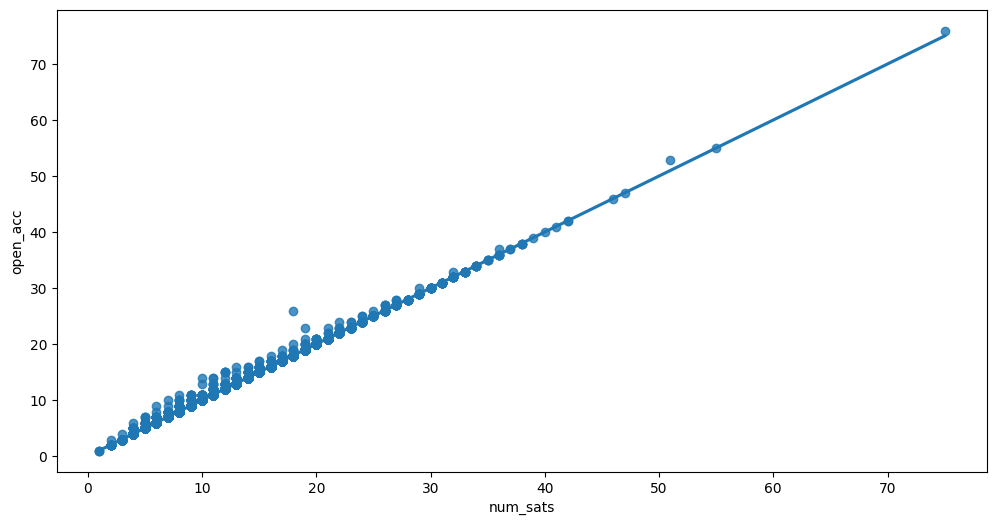

Feature interaction between `num_actv_rev_tl`/`num_rev_tl_bal_gt_0`

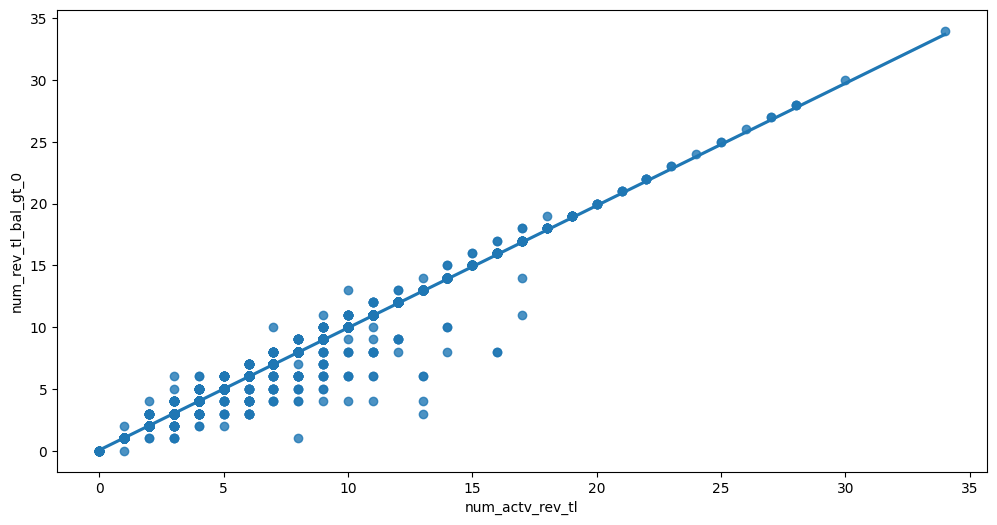

In [58]:
eda_overview = auto.dataset_overview(train_data=all_train, test_data=a_test, 
                      label='charged_off')

In [59]:
# gracias al EDA pudimos ver que hay variables que son altamente correlacionadas
# así que solo nos quedaremos con una de ellas
remove_columns_correlated = [
'total_pymnt', #total_pymnt_inv - distance 0.00
'debt_settlement_flag', #settlement_status - distance 0.00
'fico_range_high', #fico_range_low - distance 0.00
'last_fico_range_high', #last_fico_range_low - distance 0.00
'funded_amnt_inv', #loan_amnt - distance 0.00
'collection_recovery_fee', #recoveries - distance 0.00
'num_sats', #open_acc - distance 0.00
'int_rate', #sub_grade - distance 0.00
'num_actv_rev_tl',# num_rev_tl_bal_gt_0 
]

a_train = a_train.drop(columns=remove_columns_correlated)
a_val = a_val.drop(columns=remove_columns_correlated)
a_test = a_test.drop(columns=remove_columns_correlated)
all_train = all_train.drop(columns=remove_columns_correlated)

### EDA Tasa de Interes

Aseguramo de que los datos sean robustos ante la tasa de interes.  
+ Que pasaria si historicamente el banco solo ha ofrecido uno, dos, o tres tipos de tasa de interes? Como limitaria esto tus recomendaciones? 
  + El modelo estaría super sesgado a esas tasas de interés y siempre recomendaría esas tasas de interés.
+ Piensa que si solo existen ciertos tipos de tasa de interes tus datos estan sesgados o condicionados a estas tasas de interes, por lo que proponer tasas diferentes a estas causaria problemas.
  + por eso nos vamos a deshacer de todas las columnas que tengan que ver con la tasa de interes, para que el modelo no se sesgue a esas tasas de interés.

Incluso si la muestra esta sesgada (o no), imagina que este problema no existe para el resto del Notebook


In [60]:
datos_dict

,feature,description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...
...,...,...
148,settlement_amount,The loan amount that the borrower has agreed t...
149,settlement_percentage,The settlement amount as a percentage of the p...
150,settlement_term,The number of months that the borrower will be...
151,NaN,NaN


In [61]:
a_train.columns[2]
print(datos_dict[datos_dict.feature == a_train.columns[2]].feature.values[0])

loan_amnt


In [62]:
# vamos a explorar todas las features con las que nos quedamos para ver
# cuales tienen que ver con la tasa de interes
for col in a_train.columns: 
    print(f"Feature: {datos_dict[datos_dict.feature == col].feature.values}: \n \t {datos_dict[datos_dict.feature == col].description.values} \n \n" )


Feature: []: 
 	 [] 
 

Feature: ['id']: 
 	 ['A unique LC assigned ID for the loan listing.'] 
 

Feature: ['loan_amnt']: 
 	 ['The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.'] 
 

Feature: ['funded_amnt']: 
 	 ['The total amount committed to that loan at that point in time.'] 
 

Feature: ['term']: 
 	 ['The number of payments on the loan. Values are in months and can be either 36 or 60.'] 
 

Feature: ['installment']: 
 	 ['The monthly payment owed by the borrower if the loan originates.'] 
 

Feature: ['grade']: 
 	 ['LC assigned loan grade'] 
 

Feature: ['sub_grade']: 
 	 ['LC assigned loan subgrade'] 
 

Feature: ['emp_title']: 
 	 ['The job title supplied by the Borrower when applying for the loan.*'] 
 

Feature: ['emp_length']: 
 	 ['Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or mo

In [63]:
# extraemos las variables que tienen que ver con la tasa de interes
# parace solo haber quedado una variable que tiene que ver con la tasa de interes
interest_related_features = ['total_rec_int']

for feature in interest_related_features: 
    print(f"Feature: {datos_dict[datos_dict.feature == feature].feature.values}: \n \t {datos_dict[datos_dict.feature == feature].description.values} \n \n" )

Feature: ['total_rec_int']: 
 	 ['Interest received to date'] 
 



In [64]:
# nos deshacemos de las variables que tienen que ver con la tasa de interes
a_train.drop(interest_related_features, axis=1, inplace=True)
a_val.drop(interest_related_features, axis=1, inplace=True)
a_test.drop(interest_related_features, axis=1, inplace=True)
all_train.drop(interest_related_features, axis=1, inplace=True)

### EDA de variable objetivo

## Target variable analysis

### Label Insights

 - Mild minority class imbalance detected - imbalance ratio is `22.40%`. Recommendations:
   - downsample majority class `0` to improve the balance
   - upweight downsampled class so that `sample_weight = original_weight x downsampling_factor`.[TabularPredictor](https://auto.gluon.ai/stable/api/autogluon.predictor.html#module-0) supports this via `sample_weight` parameter

,count,mean,std,min,25%,50%,75%,max,dtypes,unique,missing_count,missing_ratio,raw_type,special_types
charged_off,10000,0.183,0.386686,0.0,0.0,0.0,0.0,1.0,uint8,2,,,int,


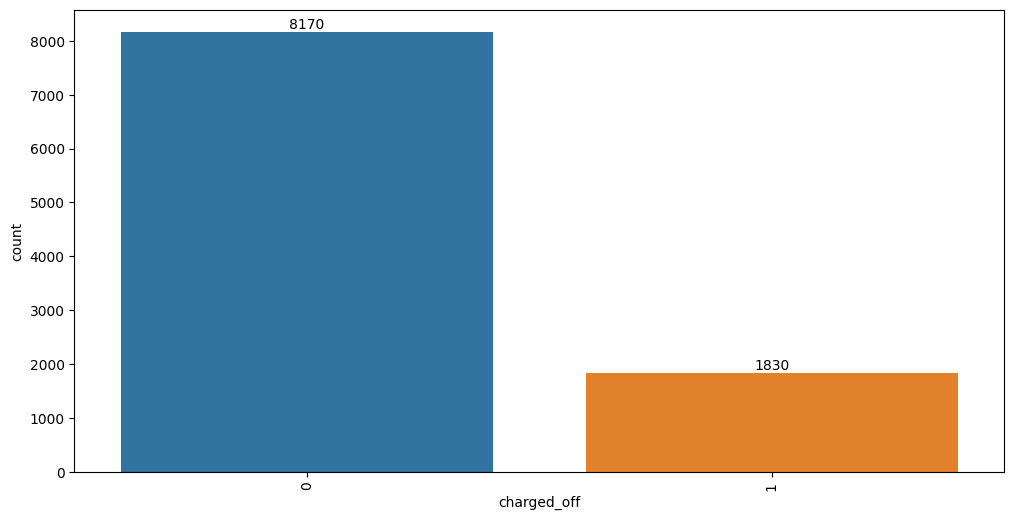

### Target variable correlations

**`train_data` - `spearman` correlation matrix; focus: absolute correlation for `charged_off` >= `0.5` (sample size: 10000)**

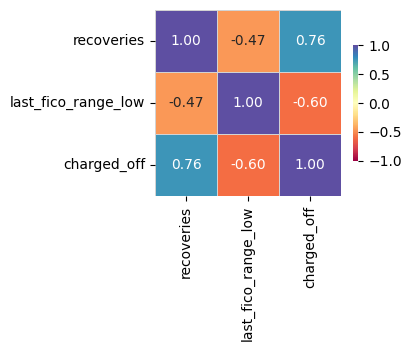

**Feature interaction between `recoveries`/`charged_off` in `train_data` (sample size: 10000)**

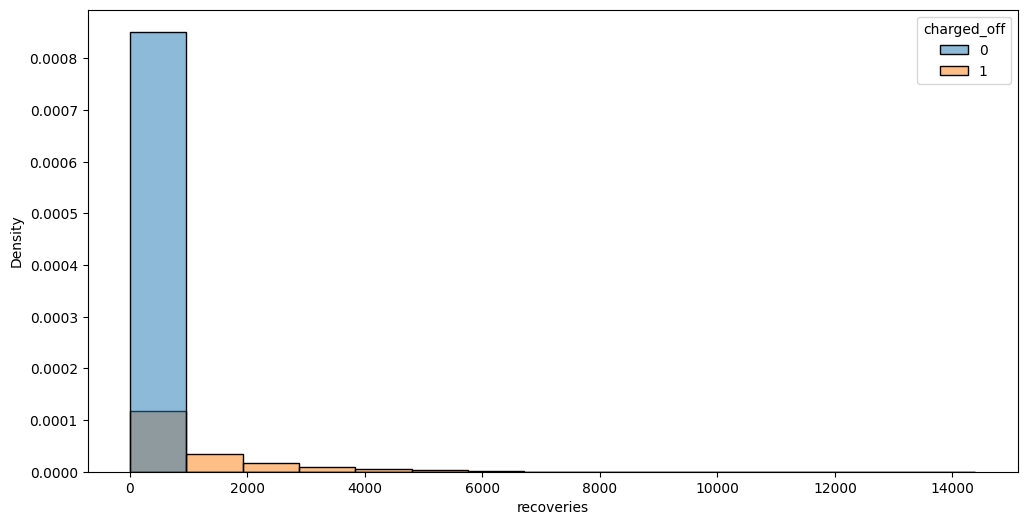

**Feature interaction between `last_fico_range_low`/`charged_off` in `train_data` (sample size: 10000)**

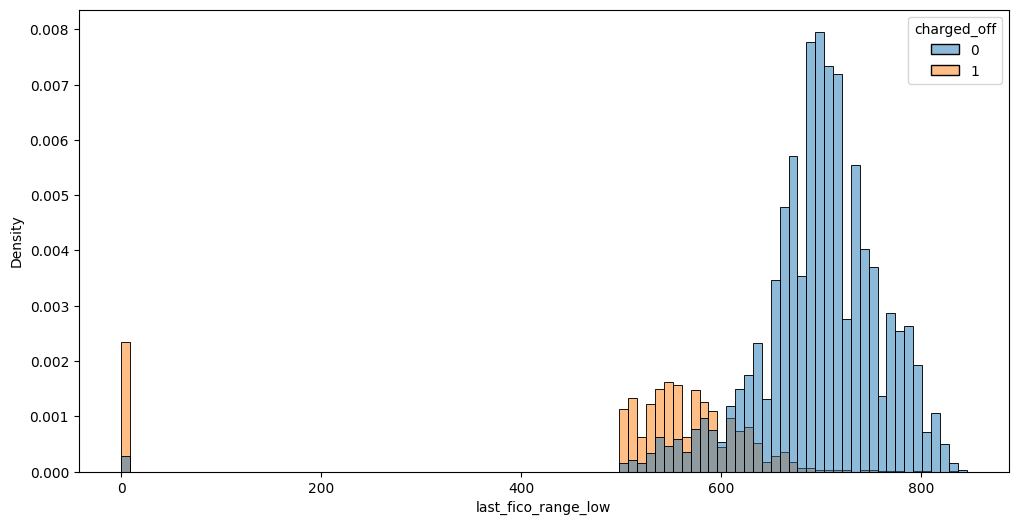

In [65]:
auto.target_analysis(train_data=all_train, label='charged_off')

### Covarianzas entre variables

In [66]:
auto.covariate_shift_detection(train_data=all_train, test_data=a_test, label='charged_off')

We did not detect a substantial difference between the training and test X distributions.

In [67]:
auto.covariate_shift_detection(train_data=a_train, test_data=a_val, label='charged_off')

We did not detect a substantial difference between the training and test X distributions.

No parece haber una correlación fuerte entre las variables, por lo que no es necesario eliminar ninguna variable.

### Modelaje

No path specified. Models will be saved in: "AutogluonModels\ag-20231127_032822\"


### Model Prediction for charged_off

Using validation data for `Test` points

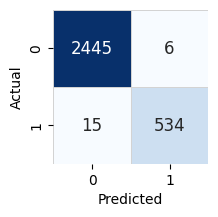

### Model Leaderboard

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT,0.993,0.997143,0.009998,0.009997,0.804463,0.009998,0.009997,0.804463,1,True,1


### Feature Importance for Trained Model

,importance,stddev,p_value,n,p99_high,p99_low
recoveries,0.056133,0.002142,2.540213e-07,5,0.060544,0.051723
last_pymnt_amnt,0.053800,0.000901,9.419993e-09,5,0.055654,0.051946
last_fico_range_low,0.049467,0.003176,2.028774e-06,5,0.056007,0.042927
last_pymnt_d,0.019800,0.001880,9.631386e-06,5,0.023670,0.015930
total_rec_prncp,0.014267,0.001038,3.341101e-06,5,0.016404,0.012129
term,0.010133,0.000960,9.564457e-06,5,0.012111,0.008156
loan_amnt,0.003333,0.001179,1.599101e-03,5,0.005760,0.000907
installment,0.002667,0.000527,1.739457e-04,5,0.003752,0.001581
last_credit_pull_d,0.001133,0.000298,5.252890e-04,5,0.001747,0.000519
total_pymnt_inv,0.000733,0.000548,2.009311e-02,5,0.001861,-0.000394


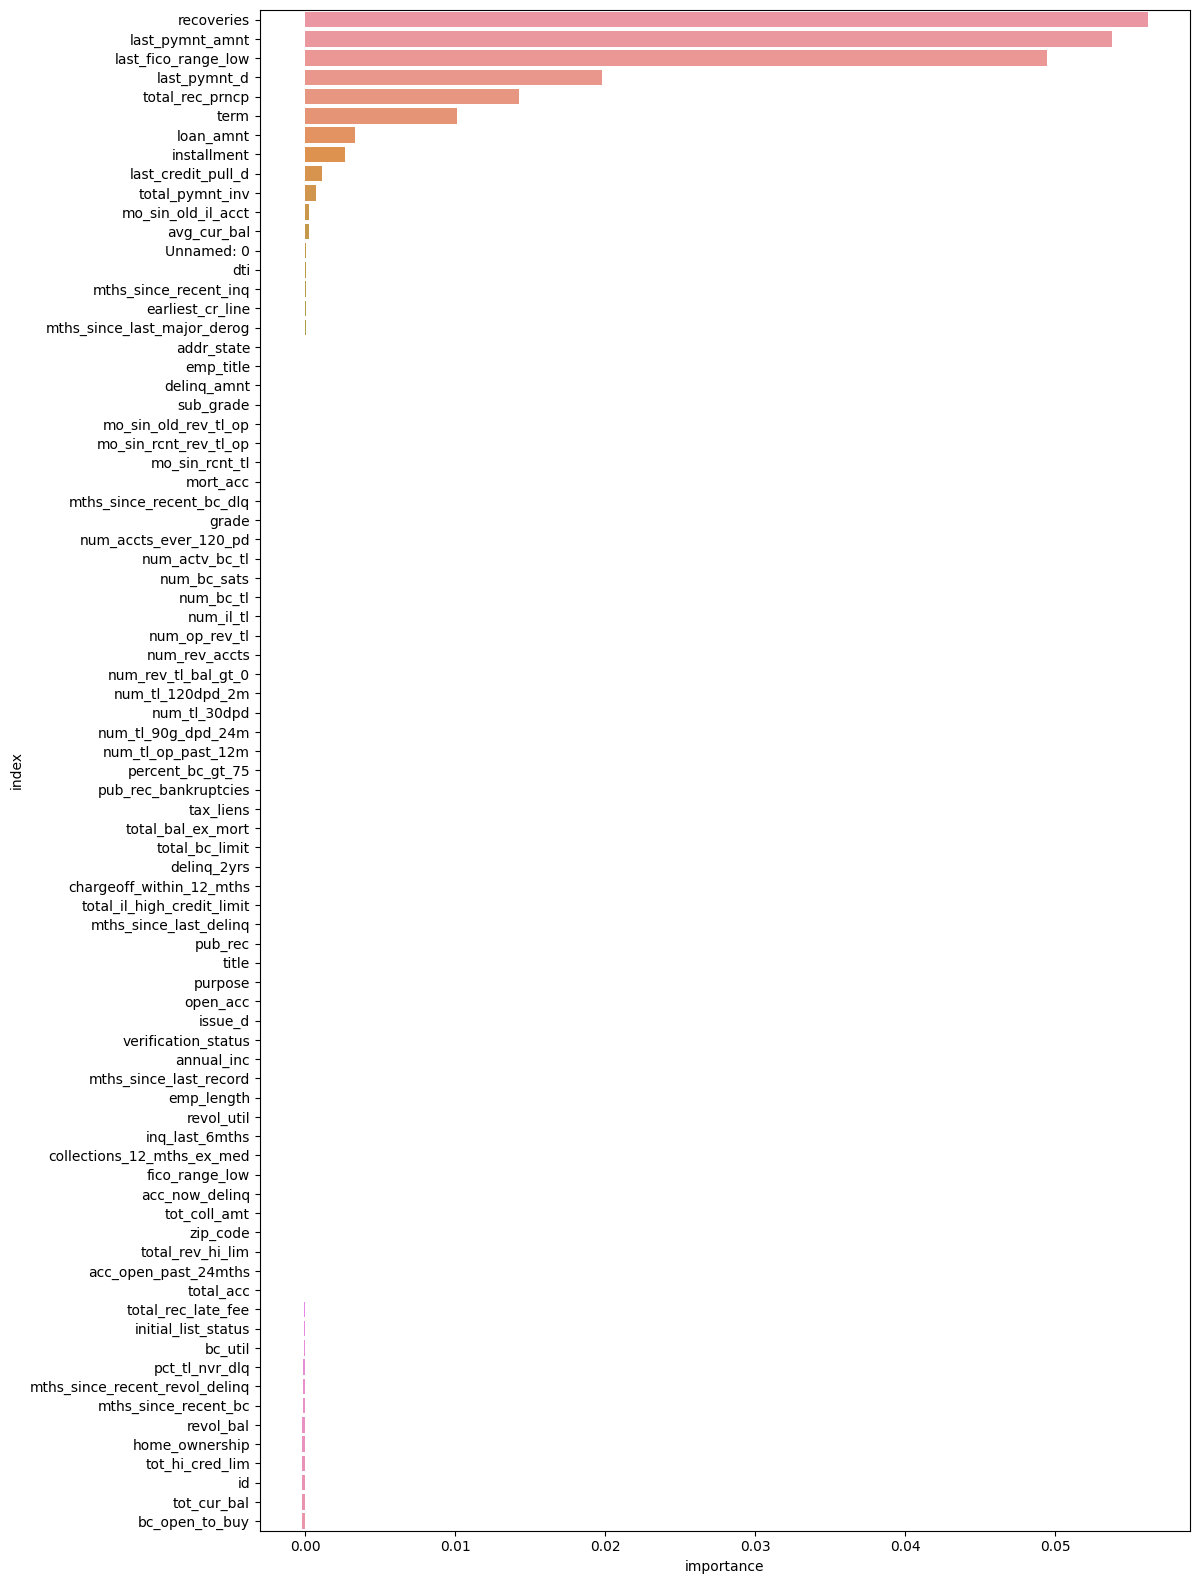

### Rows with the highest prediction error

Rows in this category worth inspecting for the causes of the error

,Unnamed: 0,id,loan_amnt,funded_amnt,term,installment,grade,sub_grade,emp_title,emp_length,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,charged_off,0,1,error
38733,80439,26260391,9225.0,9225.0,36 months,322.56,D,D1,None,None,...,151900.0,13665.0,49600.0,0.0,N,Cash,1,0.918504,0.081496,0.837009
25421,23804,34722813,10000.0,10000.0,36 months,340.13,C,C3,administrative assistant,3 years,...,23425.0,14364.0,9900.0,6500.0,N,Cash,1,0.907436,0.092564,0.814873
68256,50892,30996120,8650.0,8650.0,36 months,308.36,D,D3,Manager,10+ years,...,474708.0,18763.0,2200.0,21708.0,N,Cash,1,0.893395,0.106605,0.786790
59403,29058,34392060,30000.0,30000.0,60 months,658.88,B,B4,Manager Managed Care Contracting,10+ years,...,219171.0,34739.0,20900.0,35801.0,N,Cash,1,0.845651,0.154349,0.691302
2838,94757,24144490,14000.0,14000.0,60 months,325.62,C,C3,None,None,...,352333.0,33990.0,5000.0,35260.0,N,Cash,1,0.797852,0.202148,0.595704
14245,60135,29664395,25000.0,25000.0,36 months,779.84,A,A4,System Engineer,4 years,...,100554.0,38489.0,64700.0,23663.0,N,Cash,1,0.797372,0.202628,0.594744
61886,44670,31537866,10500.0,10500.0,36 months,351.22,B,B5,None,None,...,24536.0,16709.0,3000.0,19036.0,N,Cash,1,0.789519,0.210481,0.579038
43809,51855,30625955,10000.0,10000.0,36 months,304.36,A,A1,None,None,...,80128.0,16851.0,67600.0,12528.0,N,Cash,1,0.745662,0.254338,0.491323
60074,93947,464181,13000.0,13000.0,36 months,450.59,C,C5,Administrative Specialist II,1 year,...,38600.0,16001.0,27100.0,0.0,N,Cash,0,0.273902,0.726098,0.452196
11496,46215,31567205,12600.0,12600.0,36 months,461.81,E,E1,Account Manager,< 1 year,...,235931.0,37840.0,16400.0,31500.0,N,Cash,0,0.313994,0.686006,0.372012


### Rows with the least distance vs other class

Rows in this category are the closest to the decision boundary vs the other class and are good candidates for additional labeling

,Unnamed: 0,id,loan_amnt,funded_amnt,term,installment,grade,sub_grade,emp_title,emp_length,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,charged_off,0,1,error
29119,87819,25217298,8000.0,8000.0,36 months,255.04,B,B1,Machinist,5 years,...,176911.0,7970.0,13000.0,0.0,N,Cash,0,0.496198,0.503802,0.007604
57405,96281,21100461,18900.0,18900.0,60 months,511.21,E,E4,Manager,8 years,...,51898.0,42164.0,6300.0,43598.0,N,Cash,1,0.518879,0.481121,0.037759
8221,9674,35979558,10000.0,10000.0,60 months,234.30,C,C4,Senior Office Assistant,2 years,...,96077.0,83498.0,35200.0,53277.0,N,Cash,1,0.527094,0.472906,0.054188
55947,44304,31227651,6000.0,6000.0,36 months,203.18,C,C2,Laboratory,4 years,...,43034.0,27671.0,4100.0,31434.0,N,Cash,1,0.564347,0.435653,0.128694
44195,8880,36440170,25000.0,25000.0,36 months,777.55,A,A4,Chief Operations Supervisor,10+ years,...,23263.0,18738.0,1800.0,0.0,N,Cash,1,0.576496,0.423504,0.152992
35237,62284,29254321,9000.0,9000.0,36 months,309.75,C,C4,sales associate,1 year,...,9110.0,6787.0,4400.0,3010.0,N,Cash,1,0.598136,0.401864,0.196271
59768,53781,30575483,25000.0,25000.0,36 months,773.30,A,A3,Controller,< 1 year,...,502450.0,36259.0,55400.0,0.0,N,Cash,1,0.600699,0.399301,0.201398
67807,40322,29453909,21600.0,21600.0,36 months,698.50,B,B2,Financial Managment Analyst II,10+ years,...,165471.0,60906.0,29200.0,45541.0,N,Cash,0,0.380420,0.619580,0.239160
26710,34264,33130799,15000.0,15000.0,36 months,491.01,B,B3,Associate Analyst,7 years,...,58875.0,33687.0,23500.0,19075.0,N,Cash,0,0.366441,0.633559,0.267118
53117,88257,24865158,8000.0,8000.0,36 months,264.46,B,B4,nanny,10+ years,...,35248.0,24083.0,13000.0,16248.0,N,Cash,0,0.327233,0.672767,0.345534


In [68]:
# modelo simple para tener una referencia
state = auto.quick_fit(
    all_train, 
    'charged_off', 
    return_state=True,
    show_feature_importance_barplots=True
)

,Unnamed: 0,id,loan_amnt,funded_amnt,term,installment,grade,sub_grade,emp_title,emp_length,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,charged_off,0,1,error
38733,80439,26260391,9225.0,9225.0,36 months,322.56,D,D1,None,None,...,151900.0,13665.0,49600.0,0.0,N,Cash,1,0.918504,0.081496,0.837009


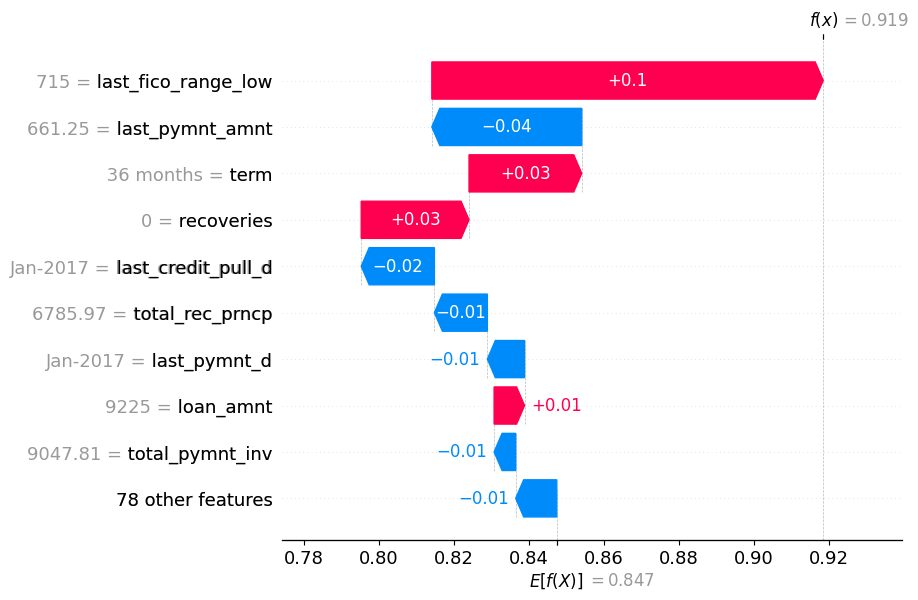

In [69]:
# vemos las variables con mayor error
auto.explain_rows(
    train_data=all_train,
    model=state.model,
    display_rows=True,
    plot='waterfall',
    rows=state.model_evaluation.highest_error[:1]
)

In [70]:
save_path = 'AutogluonModels'


predictor = TabularPredictor(label='charged_off', path=save_path, 
                             problem_type='binary',
                             eval_metric='log_loss', # Es mas rapido de entrenar
                             sample_weight='balance_weight' # Pesos a a la funcion de perdida
                             )

In [71]:
predictor_val = TabularPredictor(label='charged_off', path=os.path.join(save_path,'validation'), 
                             problem_type='binary',
                             eval_metric='log_loss', # Es mas rapido de entrenar, luego evaluamos otras metricas
                             sample_weight='balance_weight', # Pesos a a la funcion de perdida
                             ).fit(
                                 train_data = a_train,
                                 time_limit = None, # Seconds o None para no poner limite
                                 presets='medium_quality',
                                 num_cpus = 8,
                                 tuning_data = a_val,
                                 hyperparameters = {
                                'NN_TORCH': {},
                                # Gradient Boosting Machine: es un ensamble de arboles de decision                                     
                                'GBM': [{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge'],
                                'CAT': {},
                                'XGB': {},
                                'FASTAI': {},
                                'RF': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}},
                                       {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}},
                                       {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
                                 'XT': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}},
                                        {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, 
                                        {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
                                'KNN': [{'weights': 'uniform', 'ag_args': {'name_suffix': 'Unif'}},
                                        {'weights': 'distance', 'ag_args': {'name_suffix': 'Dist'}}],
                            }
                             )

Presets specified: ['medium_quality']
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Using predefined sample weighting strategy: balance_weight. Evaluation metrics will ignore sample weights, specify weight_evaluation=True to instead report weighted metrics.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\validation\"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   302.14 GB / 2000.38 GB (15.1%)
Train Data Rows:    55128
Train Data Columns: 87
Tuning Data Rows:    13782
Tuning Data Columns: 87
Label Column: charged_off
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Assigning sample weights to balance differences in frequency of classes.
Using Feature Ge

In [72]:
predictor_val.feature_importance(a_val)

These features in provided data are not utilized by the predictor and will be ignored: ['funded_amnt', 'pymnt_plan', 'out_prncp', 'out_prncp_inv', 'policy_code', 'application_type', 'hardship_flag', 'disbursement_method']
Computing feature importance via permutation shuffling for 79 features using 5000 rows with 5 shuffle sets...


	94.02s	= Expected runtime (18.8s per shuffle set)
	46.65s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
total_rec_prncp,0.702630,0.030840,4.442437e-07,5,7.661305e-01,0.639130
loan_amnt,0.385288,0.010621,6.923029e-08,5,4.071573e-01,0.363419
recoveries,0.257662,0.012485,6.593739e-07,5,2.833683e-01,0.231956
last_pymnt_amnt,0.056448,0.003559,1.885295e-06,5,6.377557e-02,0.049121
last_fico_range_low,0.016432,0.003514,2.364407e-04,5,2.366822e-02,0.009196
...,...,...,...,...,...,...
mths_since_recent_bc_dlq,-0.000011,0.000006,9.939258e-01,5,6.528198e-07,-0.000023
total_il_high_credit_limit,-0.000021,0.000006,9.994129e-01,5,-9.174924e-06,-0.000032
total_acc,-0.000025,0.000012,9.953386e-01,5,-4.913363e-07,-0.000049
bc_util,-0.000026,0.000026,9.530108e-01,5,2.846294e-05,-0.000080


#### Mejor modelo en validacion

In [73]:
predictor_val.leaderboard(a_val, extra_metrics=['mcc', 'balanced_accuracy', 'f1', 'precision', 'roc_auc'])

                  model  score_test       mcc  balanced_accuracy        f1  precision   roc_auc  score_val  pred_time_test  pred_time_val     fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   -0.002496  0.997142           0.997828  0.997674   0.999612  0.999993  -0.002496        0.343346       0.278565  1059.329580                 0.007009                0.001000           0.964875            2       True         14
1               XGBoost   -0.002792  0.997380           0.998021  0.997869   0.999612  0.999990  -0.002792        0.152366       0.124024    35.010334                 0.152366                0.124024          35.010334            1       True         11
2              LightGBM   -0.003417  0.997380           0.997872  0.997868   1.000000  0.999991  -0.003417        0.091733       0.075027     3.729102                 0.091733                0.075027           3.729102            1       

,model,score_test,mcc,balanced_accuracy,f1,precision,roc_auc,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.002496,0.997142,0.997828,0.997674,0.999612,0.999993,-0.002496,0.343346,0.278565,1059.329580,0.007009,0.001000,0.964875,2,True,14
1,XGBoost,-0.002792,0.997380,0.998021,0.997869,0.999612,0.999990,-0.002792,0.152366,0.124024,35.010334,0.152366,0.124024,35.010334,1,True,11
2,LightGBM,-0.003417,0.997380,0.997872,0.997868,1.000000,0.999991,-0.003417,0.091733,0.075027,3.729102,0.091733,0.075027,3.729102,1,True,4
3,CatBoost,-0.004301,0.995712,0.997411,0.996514,0.997674,0.999987,-0.004301,0.092238,0.078513,1019.625268,0.092238,0.078513,1019.625268,1,True,7
4,LightGBMLarge,-0.005938,0.993803,0.995417,0.994951,0.998830,0.999971,-0.005938,0.099241,0.068509,4.664616,0.099241,0.068509,4.664616,1,True,13
5,LightGBMXT,-0.007953,0.991893,0.994614,0.993401,0.996884,0.999949,-0.007953,0.198259,0.155322,5.264563,0.198259,0.155322,5.264563,1,True,3
6,NeuralNetTorch,-0.014851,0.981847,0.988424,0.985202,0.991768,0.999759,-0.014851,0.277968,0.272078,73.647950,0.277968,0.272078,73.647950,1,True,12
7,NeuralNetFastAI,-0.015831,0.984727,0.990745,0.987568,0.991806,0.999550,-0.015831,0.445622,0.283605,131.129203,0.445622,0.283605,131.129203,1,True,10
8,RandomForestEntr,-0.032683,0.984002,0.988082,0.986906,0.997235,0.999823,-0.032683,0.451456,0.139230,5.390946,0.451456,0.139230,5.390946,1,True,6
9,RandomForestGini,-0.033987,0.984248,0.987680,0.987084,0.998812,0.999819,-0.033987,0.589190,0.142077,5.167076,0.589190,0.142077,5.167076,1,True,5


#### Mejor modelo en test

In [75]:
predictor_val.leaderboard(a_test, 
                          extra_metrics=['mcc', 'balanced_accuracy', 'f1', 'precision', 'roc_auc'])

                  model  score_test       mcc  balanced_accuracy        f1  precision   roc_auc  score_val  pred_time_test  pred_time_val     fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   -0.003336  0.996761           0.997369  0.997362   1.000000  0.999986  -0.002496        0.436399       0.278565  1059.329580                 0.006999                0.001000           0.964875            2       True         14
1               XGBoost   -0.003771  0.996188           0.997143  0.996897   0.999378  0.999969  -0.002792        0.190338       0.124024    35.010334                 0.190338                0.124024          35.010334            1       True         11
2              LightGBM   -0.004517  0.996760           0.997488  0.997363   0.999689  0.999984  -0.003417        0.113933       0.075027     3.729102                 0.113933                0.075027           3.729102            1       

,model,score_test,mcc,balanced_accuracy,f1,precision,roc_auc,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.003336,0.996761,0.997369,0.997362,1.000000,0.999986,-0.002496,0.436399,0.278565,1059.329580,0.006999,0.001000,0.964875,2,True,14
1,XGBoost,-0.003771,0.996188,0.997143,0.996897,0.999378,0.999969,-0.002792,0.190338,0.124024,35.010334,0.190338,0.124024,35.010334,1,True,11
2,LightGBM,-0.004517,0.996760,0.997488,0.997363,0.999689,0.999984,-0.003417,0.113933,0.075027,3.729102,0.113933,0.075027,3.729102,1,True,4
3,CatBoost,-0.005219,0.995234,0.996726,0.996122,0.998445,0.999931,-0.004301,0.125129,0.078513,1019.625268,0.125129,0.078513,1019.625268,1,True,7
4,LightGBMLarge,-0.007257,0.993325,0.995298,0.994564,0.998130,0.999916,-0.005938,0.097728,0.068509,4.664616,0.097728,0.068509,4.664616,1,True,13
5,LightGBMXT,-0.009885,0.990844,0.994476,0.992554,0.995023,0.999775,-0.007953,0.178968,0.155322,5.264563,0.178968,0.155322,5.264563,1,True,3
6,NeuralNetTorch,-0.016122,0.980698,0.987941,0.984270,0.990596,0.999667,-0.014851,0.334265,0.272078,73.647950,0.334265,0.272078,73.647950,1,True,12
7,NeuralNetFastAI,-0.019824,0.982439,0.989929,0.985714,0.989093,0.999162,-0.015831,0.499561,0.283605,131.129203,0.499561,0.283605,131.129203,1,True,10
8,RandomForestEntr,-0.031897,0.983772,0.987084,0.986679,0.999365,0.999775,-0.032683,0.233313,0.139230,5.390946,0.233313,0.139230,5.390946,1,True,6
9,RandomForestGini,-0.033196,0.983011,0.986227,0.986035,1.000000,0.999812,-0.033987,0.234455,0.142077,5.167076,0.234455,0.142077,5.167076,1,True,5


In [76]:
predicted_prob_val = predictor_val.predict_proba(a_test)
summary_val = predictor_val.evaluate_predictions(a_test['charged_off'], predicted_prob_val, auxiliary_metrics=True, detailed_report=True)
summary_val

Evaluation: log_loss on test data: -0.0033364209487934966
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "log_loss": -0.0033364209487934966,
    "accuracy": 0.9990132342697934,
    "balanced_accuracy": 0.9973692355307955,
    "mcc": 0.9967606438040957,
    "roc_auc": 0.9999860473262752,
    "f1": 0.9973622963537626,
    "precision": 1.0,
    "recall": 0.9947384710615909
}
Detailed (per-class) classification report:
{
    "0": {
        "precision": 0.998786927358356,
        "recall": 1.0,
        "f1-score": 0.9993930955695978,
        "support": 13997
    },
    "1": {
        "precision": 1.0,
        "recall": 0.9947384710615909,
        "f1-score": 0.9973622963537626,
        "support": 3231
    },
    "accuracy": 0.9990132342697934,
    "macro avg": {
        "precision": 0.9993934636791779,
        "recall": 0.9973692355307955,
        "f1-score": 0.9983776959616801,
        "support":

{'log_loss': -0.0033364209487934966,
 'accuracy': 0.9990132342697934,
 'balanced_accuracy': 0.9973692355307955,
 'mcc': 0.9967606438040957,
 'roc_auc': 0.9999860473262752,
 'f1': 0.9973622963537626,
 'precision': 1.0,
 'recall': 0.9947384710615909,
 'confusion_matrix':        0     1
 0  13997     0
 1     17  3214,
 'classification_report': {'0': {'precision': 0.998786927358356,
   'recall': 1.0,
   'f1-score': 0.9993930955695978,
   'support': 13997},
  '1': {'precision': 1.0,
   'recall': 0.9947384710615909,
   'f1-score': 0.9973622963537626,
   'support': 3231},
  'accuracy': 0.9990132342697934,
  'macro avg': {'precision': 0.9993934636791779,
   'recall': 0.9973692355307955,
   'f1-score': 0.9983776959616801,
   'support': 17228},
  'weighted avg': {'precision': 0.9990144312883044,
   'recall': 0.9990132342697934,
   'f1-score': 0.9990122323082578,
   'support': 17228}}}

#### Validation con solo el mejor modelo interpretable

In [77]:
predictor_good = TabularPredictor(label='charged_off', path=os.path.join(save_path,'good_quality'), 
                             problem_type='binary',
                             eval_metric='log_loss', # Es mas rapido de entrenar, luego evaluamos otras metricas
                             sample_weight='balance_weight', # Pesos a a la funcion de perdida
                             ).fit(
                                 train_data = all_train,
                                 time_limit = None, # Seconds o None para no poner limite
                                 presets='good_quality',
                                 num_cpus = 8,
                                 #tuning_data = a_val, # Sin val para good_quality
                                 hyperparameters = {
                                #'NN_TORCH': {},
                                'GBM': [{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge'],
                                #'CAT': {},
                                #'XGB': {},
                                #'FASTAI': {},
                                # 'RF': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}},
                                #        {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}},
                                #        {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
                                # 'XT': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}},
                                #        {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, 
                                #        {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
                                # 'KNN': [{'weights': 'uniform', 'ag_args': {'name_suffix': 'Unif'}},
                                #         {'weights': 'distance', 'ag_args': {'name_suffix': 'Dist'}}],
                            }
                             )

Presets specified: ['good_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=1
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Using predefined sample weighting strategy: balance_weight. Evaluation metrics will ignore sample weights, specify weight_evaluation=True to instead report weighted metrics.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\good_quality\"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   306.05 GB / 2000.38 GB (15.3%)
Train Data Rows:    68910
Train Data Columns: 87
Label Column: charged_off
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Assigning sample weights to balance differences i

In [78]:
predictor_good.feature_importance(all_train)


These features in provided data are not utilized by the predictor and will be ignored: ['funded_amnt', 'pymnt_plan', 'out_prncp', 'out_prncp_inv', 'policy_code', 'application_type', 'hardship_flag', 'disbursement_method']
Computing feature importance via permutation shuffling for 79 features using 5000 rows with 5 shuffle sets...


	100.91s	= Expected runtime (20.18s per shuffle set)
	40.9s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
total_rec_prncp,5.701162e-01,2.411653e-02,3.833112e-07,5,6.197725e-01,5.204600e-01
recoveries,3.518445e-01,2.216377e-02,1.879571e-06,5,3.974800e-01,3.062089e-01
loan_amnt,3.015323e-01,8.462608e-03,7.437155e-08,5,3.189569e-01,2.841077e-01
last_pymnt_amnt,7.257384e-02,6.760849e-03,8.934228e-06,5,8.649452e-02,5.865316e-02
last_fico_range_low,8.758128e-03,3.232140e-03,1.872742e-03,5,1.541315e-02,2.103108e-03
...,...,...,...,...,...,...
num_tl_90g_dpd_24m,4.782107e-09,2.730415e-08,3.576500e-01,5,6.100173e-08,-5.143752e-08
collections_12_mths_ex_med,2.470849e-09,5.559529e-09,1.882884e-01,5,1.391800e-08,-8.976299e-09
acc_now_delinq,1.483583e-09,3.419161e-09,1.934351e-01,5,8.523683e-09,-5.556516e-09
delinq_amnt,3.097044e-10,4.498747e-10,9.927591e-02,5,1.236003e-09,-6.165939e-10


In [79]:
datos_dict[datos_dict.feature == 'total_rec_prncp']

,feature,description
109,total_rec_prncp,Principal received to date


In [80]:
predictor_good.leaderboard(all_train, extra_metrics=['mcc', 'balanced_accuracy', 'f1', 'precision', 'roc_auc'])

                       model  score_test  mcc  balanced_accuracy   f1  precision  roc_auc  score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       LightGBM_BAG_L1_FULL   -0.000002  1.0                1.0  1.0        1.0      1.0        NaN        0.394963            NaN   3.641160                 0.394963                     NaN           3.641160            1       True          6
1   WeightedEnsemble_L2_FULL   -0.000068  1.0                1.0  1.0        1.0      1.0        NaN        1.044611            NaN  10.671502                 0.014987                     NaN           0.851020            2       True          8
2     LightGBMXT_BAG_L1_FULL   -0.000874  1.0                1.0  1.0        1.0      1.0        NaN        0.397080            NaN   3.151266                 0.397080                     NaN           3.151266            1       True          5
3  LightGBMLarge

,model,score_test,mcc,balanced_accuracy,f1,precision,roc_auc,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM_BAG_L1_FULL,-0.000002,1.0,1.0,1.0,1.0,1.0,NaN,0.394963,NaN,3.641160,0.394963,NaN,3.641160,1,True,6
1,WeightedEnsemble_L2_FULL,-0.000068,1.0,1.0,1.0,1.0,1.0,NaN,1.044611,NaN,10.671502,0.014987,NaN,0.851020,2,True,8
2,LightGBMXT_BAG_L1_FULL,-0.000874,1.0,1.0,1.0,1.0,1.0,NaN,0.397080,NaN,3.151266,0.397080,NaN,3.151266,1,True,5
3,LightGBMLarge_BAG_L1_FULL,-0.001099,1.0,1.0,1.0,1.0,1.0,NaN,0.237581,NaN,3.028056,0.237581,NaN,3.028056,1,True,7
4,WeightedEnsemble_L2,NaN,NaN,NaN,NaN,NaN,NaN,-0.004542,NaN,6.064868,71.002769,NaN,0.003002,0.851020,2,False,4
5,LightGBM_BAG_L1,NaN,NaN,NaN,NaN,NaN,NaN,-0.004736,NaN,2.388841,25.496546,NaN,2.388841,25.496546,1,False,2
6,LightGBMLarge_BAG_L1,NaN,NaN,NaN,NaN,NaN,NaN,-0.009149,NaN,1.129150,20.301655,NaN,1.129150,20.301655,1,False,3
7,LightGBMXT_BAG_L1,NaN,NaN,NaN,NaN,NaN,NaN,-0.010117,NaN,2.543876,24.353548,NaN,2.543876,24.353548,1,False,1


In [81]:
predicted_prob_good = predictor_good.predict_proba(a_test)
summary_good = predictor_good.evaluate_predictions(a_test['charged_off'], predicted_prob_val, auxiliary_metrics=True, detailed_report=True)
summary_good

Evaluation: log_loss on test data: -0.0033364209487934966
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "log_loss": -0.0033364209487934966,
    "accuracy": 0.9990132342697934,
    "balanced_accuracy": 0.9973692355307955,
    "mcc": 0.9967606438040957,
    "roc_auc": 0.9999860473262752,
    "f1": 0.9973622963537626,
    "precision": 1.0,
    "recall": 0.9947384710615909
}
Detailed (per-class) classification report:
{
    "0": {
        "precision": 0.998786927358356,
        "recall": 1.0,
        "f1-score": 0.9993930955695978,
        "support": 13997
    },
    "1": {
        "precision": 1.0,
        "recall": 0.9947384710615909,
        "f1-score": 0.9973622963537626,
        "support": 3231
    },
    "accuracy": 0.9990132342697934,
    "macro avg": {
        "precision": 0.9993934636791779,
        "recall": 0.9973692355307955,
        "f1-score": 0.9983776959616801,
        "support":

{'log_loss': -0.0033364209487934966,
 'accuracy': 0.9990132342697934,
 'balanced_accuracy': 0.9973692355307955,
 'mcc': 0.9967606438040957,
 'roc_auc': 0.9999860473262752,
 'f1': 0.9973622963537626,
 'precision': 1.0,
 'recall': 0.9947384710615909,
 'confusion_matrix':        0     1
 0  13997     0
 1     17  3214,
 'classification_report': {'0': {'precision': 0.998786927358356,
   'recall': 1.0,
   'f1-score': 0.9993930955695978,
   'support': 13997},
  '1': {'precision': 1.0,
   'recall': 0.9947384710615909,
   'f1-score': 0.9973622963537626,
   'support': 3231},
  'accuracy': 0.9990132342697934,
  'macro avg': {'precision': 0.9993934636791779,
   'recall': 0.9973692355307955,
   'f1-score': 0.9983776959616801,
   'support': 17228},
  'weighted avg': {'precision': 0.9990144312883044,
   'recall': 0.9990132342697934,
   'f1-score': 0.9990122323082578,
   'support': 17228}}}

### Modelo Interpretable

El mejor modelo interpretable fue un LightGBM_BAG_L1_FULL
* LightGBM: modelo 
* BAG: Bagging
* L1: Regularización L1
* FULL: Utiliza todas las variables, fue entrenado con todas las variables 

### Modelo no Interpretable

El mejor modelo no interpretable fue un Ensamble

## Seleccion/Propuesta de Modelo

Explica por que sugieres el modelo, por que es bueno, por que es malo, que metrica(s) usaste para elegirlo. Basicamente tienes que convencer al banco que tu modelo es bueno. Usa graficas, tablas, etc.

Propuesta de modelo: LightGBM_BAG_L1_FULL
Logró un balanced accuracy de .99 en el set de prueba es decir que no se ve sesgado por el desbalanceo de las class. Enfocandos solo en los que tentativamente no pagarían el préstamo, el modelo logró un recall de .99, es decir que de todos los que no pagarían el préstamo, el modelo logró identificar al 99% de ellos. Finalmente, el modelo logró un accuracy en total de .99, es decir que de todos los préstamos, el modelo logró identificar al 99% de ellos. No solo eso, si no que al ser un modelo interpretable, podemos saber qué variables son las que más influyen en la decisión del modelo y podemos dar una explicación de por qué el modelo decidió dar o no el préstamo.
Ya que la diferencia entre el mejor modelo interpretable y no interpretable no es considerable, es mejor elegir el modelo interpretable. 

In [82]:
leaderborad = predictor_good.leaderboard(all_train, extra_metrics=['mcc', 'balanced_accuracy', 'f1', 'precision', 'roc_auc'])

                       model  score_test  mcc  balanced_accuracy   f1  precision  roc_auc  score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       LightGBM_BAG_L1_FULL   -0.000002  1.0                1.0  1.0        1.0      1.0        NaN        0.383013            NaN   3.641160                 0.383013                     NaN           3.641160            1       True          6
1   WeightedEnsemble_L2_FULL   -0.000068  1.0                1.0  1.0        1.0      1.0        NaN        1.018405            NaN  10.671502                 0.012997                     NaN           0.851020            2       True          8
2     LightGBMXT_BAG_L1_FULL   -0.000874  1.0                1.0  1.0        1.0      1.0        NaN        0.380080            NaN   3.151266                 0.380080                     NaN           3.151266            1       True          5
3  LightGBMLarge

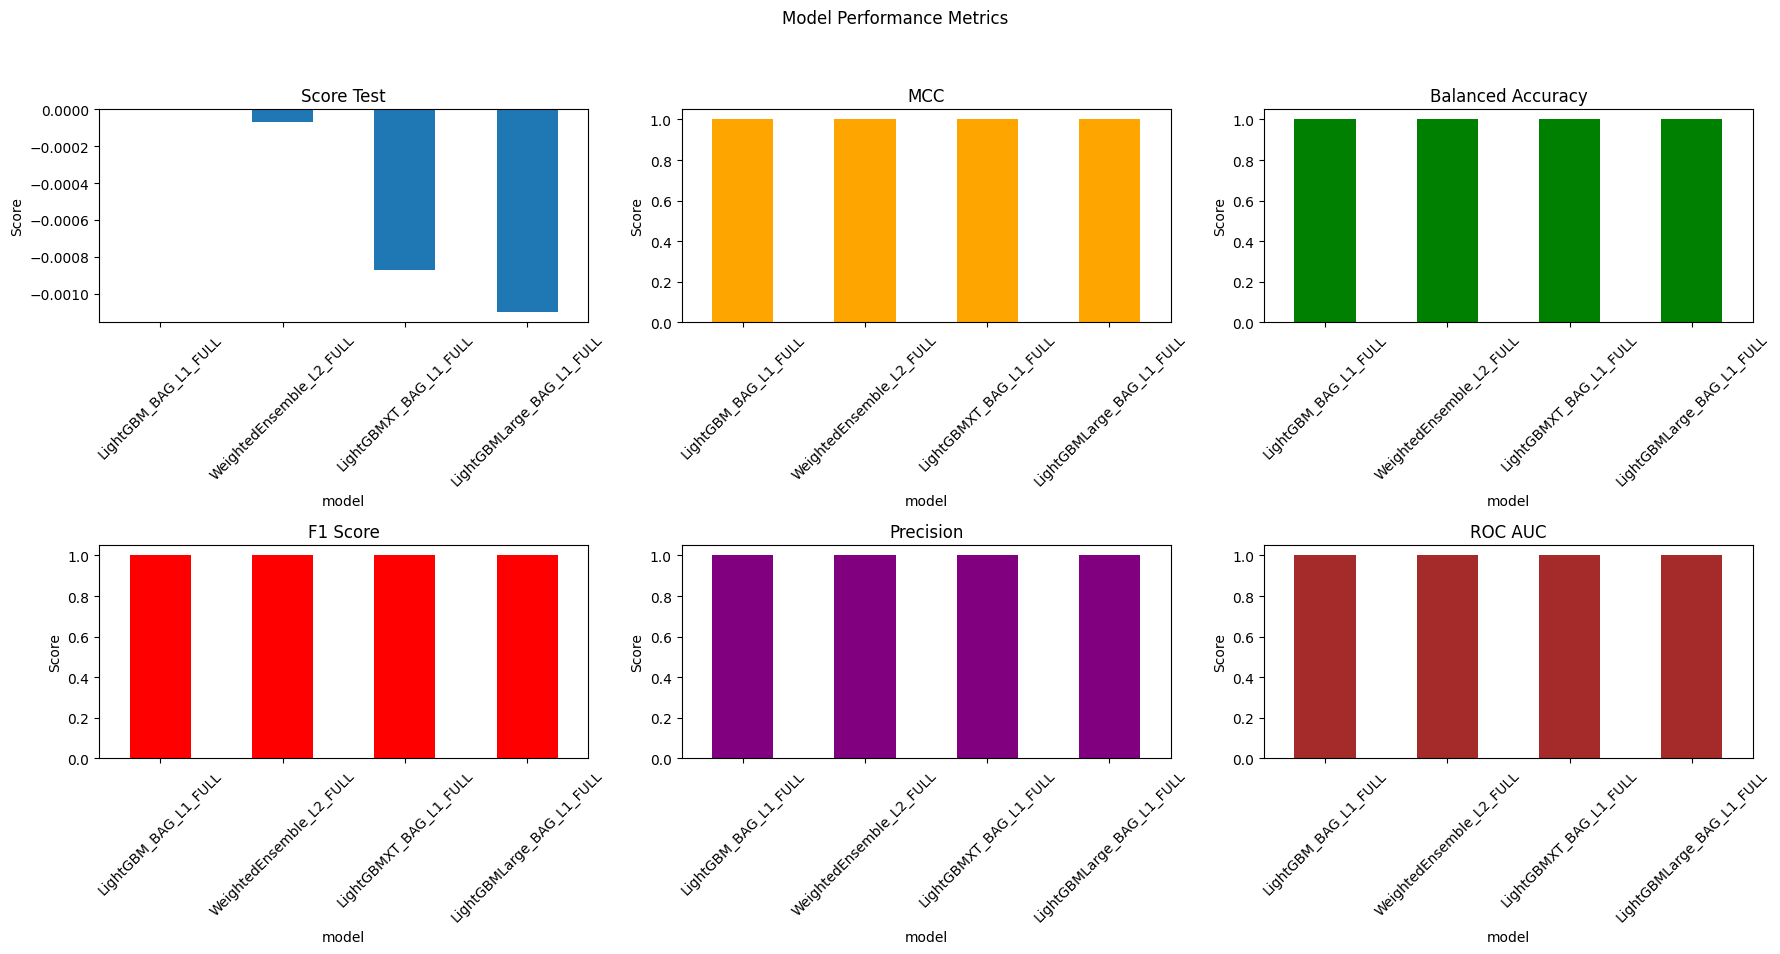

In [83]:
import matplotlib.pyplot as plt

leaderborad = leaderborad.dropna(subset=['score_test'])

# Plotting each metric in a separate subplot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.suptitle('Model Performance Metrics')

# Plotting Score Test
leaderborad.plot(x='model', y='score_test', kind='bar', ax=axes[0, 0], legend=False)
axes[0, 0].set_title('Score Test')
axes[0, 0].set_ylabel('Score')
axes[0, 0].tick_params('x', labelrotation=45)

# Plotting MCC
leaderborad.plot(x='model', y='mcc', kind='bar', ax=axes[0, 1], legend=False, color='orange')
axes[0, 1].set_title('MCC')
axes[0, 1].set_ylabel('Score')
axes[0, 1].tick_params('x', labelrotation=45)

# Plotting Balanced Accuracy
leaderborad.plot(x='model', y='balanced_accuracy', kind='bar', ax=axes[0, 2], legend=False, color='green')
axes[0, 2].set_title('Balanced Accuracy')
axes[0, 2].set_ylabel('Score')
axes[0, 2].tick_params('x', labelrotation=45)

# Plotting F1 Score
leaderborad.plot(x='model', y='f1', kind='bar', ax=axes[1, 0], legend=False, color='red')
axes[1, 0].set_title('F1 Score')
axes[1, 0].set_ylabel('Score')
axes[1, 0].tick_params('x', labelrotation=45)

# Plotting Precision
leaderborad.plot(x='model', y='precision', kind='bar', ax=axes[1, 1], legend=False, color='purple')
axes[1, 1].set_title('Precision')
axes[1, 1].set_ylabel('Score')
axes[1, 1].tick_params('x', labelrotation=45)

# Plotting ROC AUC
leaderborad.plot(x='model', y='roc_auc', kind='bar', ax=axes[1, 2], legend=False, color='brown')
axes[1, 2].set_title('ROC AUC')
axes[1, 2].set_ylabel('Score')
axes[1, 2].tick_params('x', labelrotation=45)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show plot
plt.show()

## Propuesta de tasa de interes

En esta seccion tienes que crear un sistema/funciones/codigo que le funcione en produccion al banco. El banco te pide que crees un sistema para 3 posibles escenarios.

Piensa que datos vas a utilizar para evaluar estas tasas (train o test?). Piensas que tienes que evaluar como se va a comportar en la realidad. Y tienes que tomar decisiones ahora, para el futuro (produccion)

In [84]:
all_train['loan_amnt']

0        16000.0
1         8000.0
2        28775.0
3        20000.0
4        15000.0
          ...   
68905    15000.0
68906     1400.0
68907    28000.0
68908    10000.0
68909     4200.0
Name: loan_amnt, Length: 68910, dtype: float64

In [85]:
predicted_prob_all_train = predictor_good.predict_proba(all_train)
print(predicted_prob_all_train)
# 1 = Charged Off, 0 = Fully Paid


              0         1
0      0.999954  0.000046
1      0.999957  0.000043
2      0.999961  0.000039
3      0.999959  0.000041
4      0.999961  0.000039
...         ...       ...
68905  0.999961  0.000039
68906  0.999956  0.000044
68907  0.999961  0.000039
68908  0.999956  0.000044
68909  0.999951  0.000049

[68910 rows x 2 columns]


In [86]:
# order predicted probabilities by biggest to smallest in the column 1
predicted_prob_all_train.sort_values(by=1, ascending=False)

,0,1
35385,0.000036,0.999964
6225,0.000036,0.999964
51677,0.000036,0.999964
31017,0.000037,0.999963
27652,0.000037,0.999963
...,...,...
3563,0.999963,0.000037
10814,0.999963,0.000037
4343,0.999963,0.000037
15498,0.999964,0.000036


<AxesSubplot: >

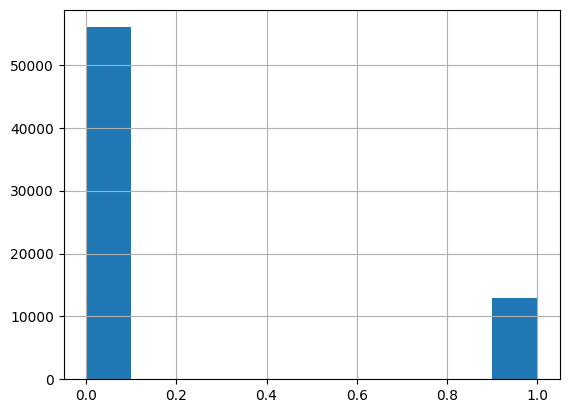

In [87]:
predicted_prob_all_train[1].hist()

In [88]:
# get avarage predicted probability for each loan amount
predicted_prob_all_train[1].mean()

0.18760611851626094

Explicación de como llego a la tasa de interes.
(Nota: lo que regresa el modelo no es la probabilidad de que pague o no pague, si no el "class score", para obtener las probabilidades tendríamos que simular, sin embargo, para efectos práciticos, podemos asumir que son probabilidades)

Loan Amount×P(repay)×(1+Interest Rate)+Loan Amount×P(default)×Recovery Rate=Loan Amount

Interest Rate= (1/P(repay))-1

Osea usas el predict_proba y usas eso para calcular cuánto te pagan a pagar lo multiplicas por 1 + i

Y eso se lo restas a lo que prestaste

Y cálculas i para que te dé 0

In [95]:
predicted_prob_all_train[0]

0        0.999954
1        0.999957
2        0.999961
3        0.999959
4        0.999961
           ...   
68905    0.999961
68906    0.999956
68907    0.999961
68908    0.999956
68909    0.999951
Name: 0, Length: 68910, dtype: float64

In [103]:
def calculate_ideal_interest_rates(expected_revenue_coefficient, predicted_probabilities):
    """
    Calculate the ideal interest rates for a set of loans to achieve a specified expected revenue coefficient.
    
    Parameters:
    expected_revenue_coefficient (float): The target revenue coefficient you aim to achieve.
    predicted_probabilities (DataFrame): A DataFrame with two columns [0, 1] where column '0' contains the probability of repayment.
    
    Returns:
    Series: A Pandas Series containing the ideal interest rates for each loan.
    """
    
    # Extract the probability of repayment for each loan
    prob_repay = predicted_probabilities[0]
    
    # Calculate the interest rate required to achieve the expected revenue coefficient for each loan
    # The interest rate is calculated as (expected_revenue_coefficient / prob_repay) - 1
    # If the probability of repayment is 0, set the interest rate to infinity, as the expected revenue cannot be achieved
    interest_rates = (expected_revenue_coefficient / prob_repay) - 1
    
    # Ensure that the interest rate is not negative and cap it to a reasonable maximum if necessary
    interest_rates = interest_rates.clip(lower=0, upper=1)  # For example, capping at 100%
    
    return interest_rates



35.01174620998448

### Valor esperado del prestamo igual a 1

Encuentra las tasas de interes para la cual el valor esperado del prestamo es igual a 1

In [105]:
(calculate_ideal_interest_rates(1, predicted_prob_all_train)*100).mean()

18.761904795264716

### Valor esperado del prestamo igual a 1.5 

Encuentra la tasa de interes para la cuel el valor esperado del prestamo es igual a 1.5

In [106]:
(calculate_ideal_interest_rates(1.5, predicted_prob_all_train)*100).mean()

59.3865083320641

### Valor esperado del prestamo 1.2 y default menor a 30%

Encuentra la tasa de interes necesaria para que el valor esperado de prestamo para el banco sea de por lo menos 1.2, pero ademas el valor esperado de los defaults sea menor al 30%

In [109]:
def calculate_ideal_interest_rates_with_default_rate(expected_revenue_coefficient, predicted_probabilities, loan_amounts, max_default_rate):
    """
    Calculate the ideal interest rates for a set of loans to achieve a specified expected revenue coefficient
    while ensuring the default rate is less than the specified maximum.
    
    Parameters:
    expected_revenue_coefficient (float): The target revenue coefficient you aim to achieve.
    predicted_probabilities (DataFrame): A DataFrame with two columns [0, 1] where column '0' contains the probability of repayment.
    loan_amounts (Series or list): The amounts of the loans given.
    max_default_rate (float): The maximum default rate allowed.
    
    Returns:
    Series: A Pandas Series containing the ideal interest rates for each loan.
    """
    
    # Extract the probability of repayment for each loan
    prob_repay = predicted_probabilities[0]
    
    # Filter loans with probability of repayment higher than the threshold (1 - max_default_rate)
    eligible_loans = prob_repay > (1 - max_default_rate)
    
    # Calculate the interest rate required to achieve the expected revenue coefficient for eligible loans
    interest_rates = pd.Series([float('inf')] * len(loan_amounts))  # Default to inf for ineligible loans
    interest_rates[eligible_loans] = (expected_revenue_coefficient / prob_repay[eligible_loans]) - 1
    
    # Ensure that the interest rate is not negative and cap it to a reasonable maximum if necessary
    interest_rates = interest_rates.clip(lower=0, upper=1)  # For example, capping at 100%
    
    return interest_rates

(calculate_ideal_interest_rates_with_default_rate(1.2, predicted_prob_all_train,
                                                 all_train['loan_amnt'], max_default_rate=0.30)).mean()*100

35.011746209984466

## Para pensar

Que pasaria con los modelos que propusiste, si resulta que la tasa de interes afecta la probabilidad de pago (lo cual es muy probable)?
+ Explica el problema que apareceria a las personas del banco para evitar problemas con tu modelo, si lo explicas mal te veras mal cuando falle.
  + Las tasas de interés calculadas aquí fueron calculadas con datos estáticos y ya dados, sin embargo, no están tomando en cuenta el efecto causal que tiene la tasa de interés en la probabilidad de que el cliente pague o no pague. Por lo que, si la tasa de interés afecta la probabilidad de pago, las tasas de interés calculadas aquí no se puede decir que sean 100% acertadas.
+ Como podrias solucionarlo (piensa si basta con agregar la tasa de interes y sobre la causalidad y correlacion)
  + Deberíamos agregar el efecto causal que tiene la tasa de interés en la probabilidad de que el cliente pague o no pague. Para esto, deberíamos hacer un experimento aleatorio controlado, donde a un grupo de clientes se les da una tasa de interés y a otro grupo de clientes se les da otra tasa de interés y se observa el efecto que tiene la tasa de interés en la probabilidad de que el cliente pague o no pague. Con esto, podríamos calcular la tasa de interés que maximice el valor esperado del préstamo.